In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## Problem Description

This project uses generative adversarial networks (GANs) to modify a set of images to look like Claude Monet images. This is a Kaggle competition at https://www.kaggle.com/competitions/gan-getting-started.

GAN architectures rely on two copmeting models: a generator and a discriminator. The generator creates the new images, learning over time to make them more Monet-like. The discriminator is trained to identify real and fake images. These two models go back and forth during training, the generator creating increasingly Monet-like images, and the discriminator calling out the fake images. Eventually the created images are good enough that the discriminator can no longer distinguish real from fake images. At this point, our GAN is able to create lifelike or Monet-like images that are indistinguishable from real ones, at least to the discriminator.

This project has a set of Monet images and a set of images that we need to modify with the GAN to look like Monet images. We will explore both sets of images before turning to architecting, training, and evaluating GANs.

The competition asks us to submit a zipped collection of generated images in order to receive a score.

## Preprocessing & Exploratory Data Analysis (EDA)

This competition provides both sets of images as JPGs and as TensorFlow TFRecord file formats for storing a sequence of binary records. We will work with the TFRecords to figure out how that format works.

TFRecords serialize structured data into binary strings. We need to know what features or keys exists for each element in the TFRecord collection. The images we are working with here have three features: `image_name`, `image`, and `target`. These are set when turning data into the TFRecord format.

The Kaggle documentation tells us that the images are all 256 x 256 pixels and are color images with the standard three RGB channels.

In [2]:
in_dir = '/kaggle/input/gan-getting-started'
out_dir = '/kaggle/working'

monet_tfrec_names = tf.io.gfile.listdir(f'{in_dir}/monet_tfrec')
monet_jpg_names = tf.io.gfile.listdir(f'{in_dir}/monet_jpg')
photo_tfrec_names = tf.io.gfile.listdir(f'{in_dir}/photo_tfrec')
photo_jpg_names = tf.io.gfile.listdir(f'{in_dir}/photo_jpg')

print(f'There are {len(monet_tfrec_names)} Monet TFRecord collections')
print(f'There are {len(monet_jpg_names)} Monet jpgs in total')
print(f'There are {len(photo_tfrec_names)} photo TFRecord collections')
print(f'There are {len(photo_jpg_names):,} photo jpgs in total')
print()
print(f'Sample of what the TFRecord files look like: {monet_tfrec_names}')

There are 5 Monet TFRecord collections
There are 300 Monet jpgs in total
There are 20 photo TFRecord collections
There are 7,038 photo jpgs in total

Sample of what the TFRecord files look like: ['monet12-60.tfrec', 'monet16-60.tfrec', 'monet08-60.tfrec', 'monet04-60.tfrec', 'monet00-60.tfrec']


In [3]:
# Find what the current tfrec files are storing as features for each record
ex = tf.train.Example()
ex.ParseFromString(
    next(iter(tf.data.TFRecordDataset(f'{in_dir}/monet_tfrec/{monet_tfrec_names[0]}').take(1))).numpy()
)
[k for k in ex.features.feature.keys()]

['image', 'target', 'image_name']

In [4]:
# Extract records from tfrec files into TFRecordDataset collection
tfrecs_monet = tf.data.TFRecordDataset([f'{in_dir}/monet_tfrec/{f}' for f in monet_tfrec_names])
tfrecs_photo = tf.data.TFRecordDataset([f'{in_dir}/photo_tfrec/{f}' for f in photo_tfrec_names])
    
# Define the features of the structured data stored in the TFRecord collections
feature_description = {
    'image_name': tf.io.FixedLenFeature([], tf.string)
    , 'image': tf.io.FixedLenFeature([], tf.string)
    , 'target': tf.io.FixedLenFeature([], tf.string)
    
}

# Pull image data out of individual TFRecord elements as dictionary mappings
# and then convert to iamges
def parse_image(record):
    return tf.io.decode_image(
        tf.io.parse_single_example(record, feature_description)['image']
        , channels=3
    )

parsed_images_monet = tfrecs_monet.map(parse_image)
parsed_images_photo = tfrecs_photo.map(parse_image)

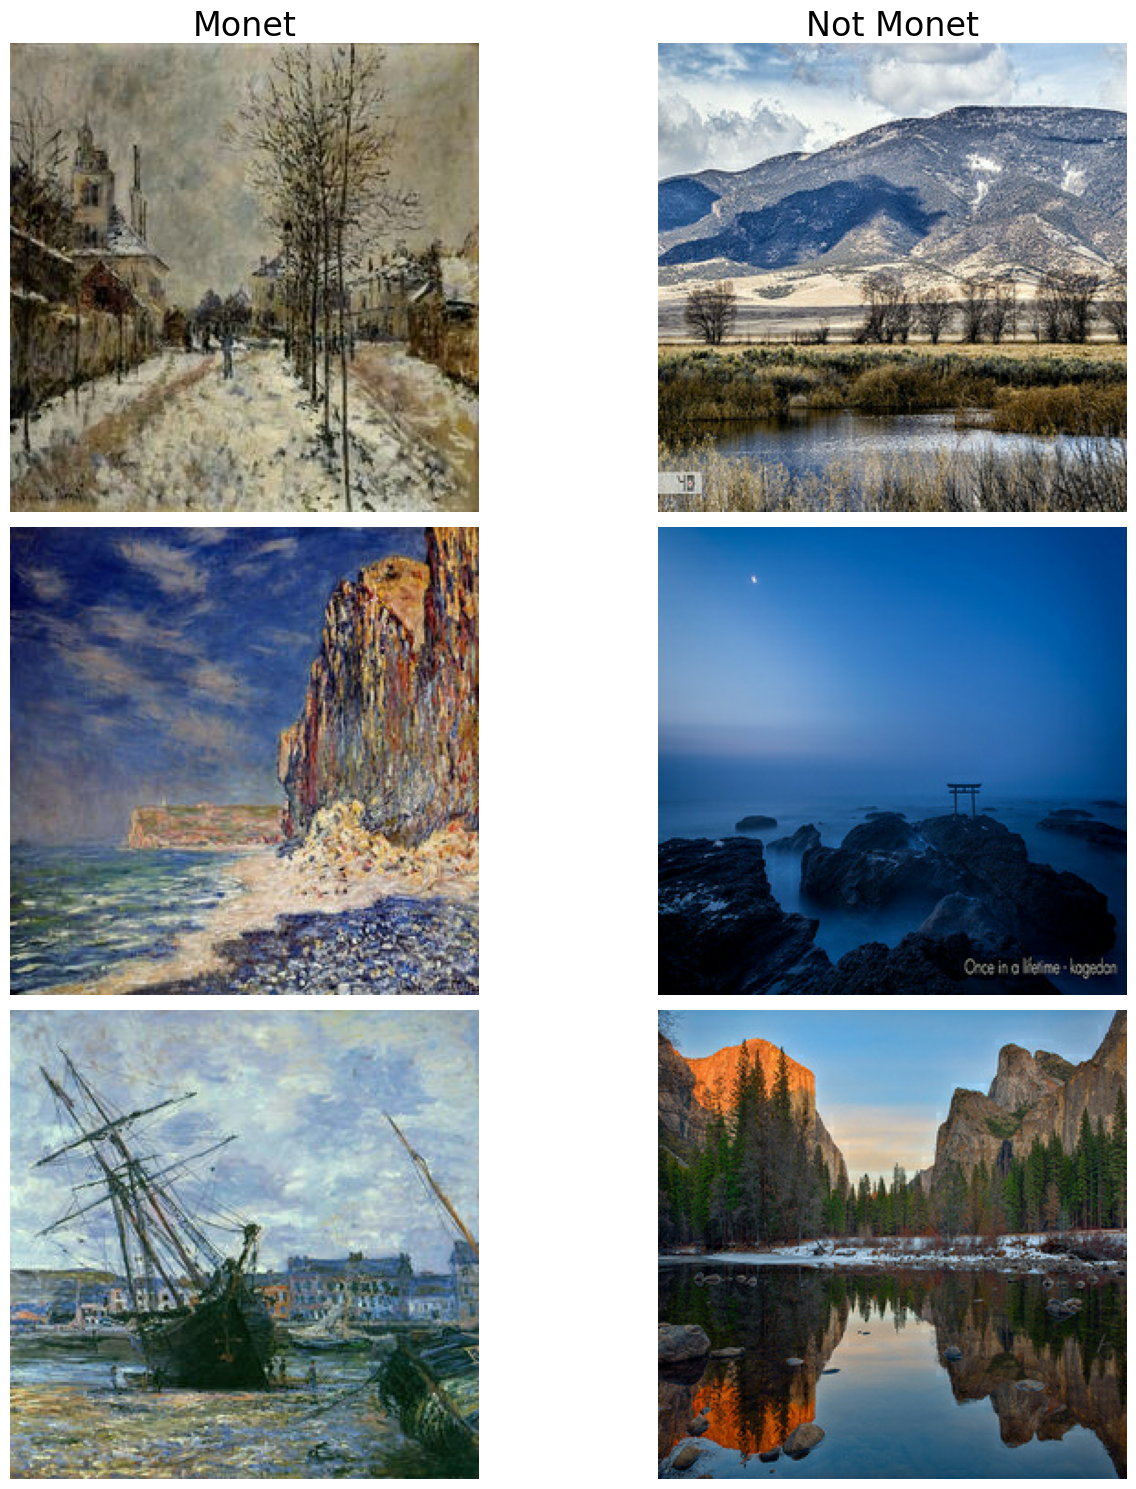

In [5]:
# Display one Monet and one non-Monet image
fig, axes = plt.subplots(
    3
    , 2
    , figsize=(15,15)
)

iter_monet = iter(parsed_images_monet)
iter_photo = iter(parsed_images_photo)

axes[0,0].imshow(next(iter_monet))
axes[0,1].imshow(next(iter_photo))
axes[1,0].imshow(next(iter_monet))
axes[1,1].imshow(next(iter_photo))
axes[2,0].imshow(next(iter_monet))
axes[2,1].imshow(next(iter_photo))

axes[0,0].set_title('Monet', fontsize=24)
axes[0,1].set_title('Not Monet', fontsize=24)

# Turn axis labels and grids off
for ax in axes.ravel():
    ax.set_axis_off()

fig.tight_layout()

We are working with 300 Monet images and 7,038 non-Monet images. The two images above show Monets on the left and non-Monets on the right. The gist of the code above extracts the TFRecord collections into TFRecordDataset datasets and pulls the image pixel data out of each element in the collections.

Next we will explore a couple of aspects of the images to see if we can find a foothold for understanding what makes them up.

I am still working on how to do the next couple of code blocks in TensorFlow, so we will use Numpy in the interim.

`parsed_images_monet` and `parsed_images_photo` are collections of TensorFlow tensors of shape (256, 256, 3). This is what we expect to see based on the Kaggle documentation. We have a 256 x 256 px image with each cell being a 3 dimensional array for the RGB channels. The general approach for the next couple of check will be to see if there are differences between the Monet and non-Monet images in terms of sums or means of values across different dimensions of the tensors.

We will get a sense of what we are working with before moving on to calculating and exploring descriptive statistics for each of the sets of images.

In [6]:
list_monet = np.array([i for i in parsed_images_monet])
list_photo = np.array([i for i in parsed_images_photo])

print(f'Dimensions of Monet image collection: {list_monet.shape}')
print(f'Dimensions of photo image collection: {list_photo.shape}')
print(f'Dimensions of first individual Monet image: {list_monet[0].shape}')
print(f'Dimensions of first individual Monet image: {list_photo[0].shape}')

list_monet[0]

Dimensions of Monet image collection: (300, 256, 256, 3)
Dimensions of photo image collection: (7038, 256, 256, 3)
Dimensions of first individual Monet image: (256, 256, 3)
Dimensions of first individual Monet image: (256, 256, 3)


array([[[138, 125, 106],
        [123, 110,  91],
        [112, 101,  83],
        ...,
        [116, 101,  68],
        [112,  98,  61],
        [108,  94,  57]],

       [[142, 129, 110],
        [135, 122, 103],
        [130, 119, 101],
        ...,
        [136, 121,  88],
        [130, 116,  79],
        [124, 110,  73]],

       [[141, 128, 109],
        [141, 128, 109],
        [143, 132, 114],
        ...,
        [150, 135, 102],
        [142, 128,  93],
        [135, 121,  84]],

       ...,

       [[101,  88,  56],
        [118, 105,  73],
        [105,  91,  62],
        ...,
        [127, 109,  71],
        [123, 105,  67],
        [122, 104,  66]],

       [[ 96,  83,  49],
        [111,  98,  66],
        [107,  94,  62],
        ...,
        [118, 100,  62],
        [117,  99,  61],
        [123, 103,  66]],

       [[108,  95,  61],
        [106,  93,  59],
        [101,  88,  56],
        ...,
        [106,  88,  50],
        [110,  90,  53],
        [120, 100,  63]]

In [7]:
print(f'Example sum of all pixels in image: {np.sum(list_monet[0]):,}')
print(f'Example sum of red channel in image: {np.sum(list_monet[0][:,:,0]):,}')
print(f'Example sum of green channel in image: {np.sum(list_monet[0][:,:,1]):,}')
print(f'Example sum of blue channel in image: {np.sum(list_monet[0][:,:,2]):,}')
print(f'Sanity check: {np.sum(list_monet[0][:,:,0]) + np.sum(list_monet[0][:,:,1]) + np.sum(list_monet[0][:,:,2]):,}')
print(f'Example mean of all pixels in image: {np.mean(list_monet[0]):.2f}')
print(f'Example mean of red channel in image: {np.mean(list_monet[0][:,:,0]):.2f}')
print(f'Example mean of green channel in image: {np.mean(list_monet[0][:,:,1]):.2f}')
print(f'Example mean of blue channel in image: {np.mean(list_monet[0][:,:,2]):.2f}')

Example sum of all pixels in image: 22,389,565
Example sum of red channel in image: 8,204,343
Example sum of green channel in image: 7,766,019
Example sum of blue channel in image: 6,419,203
Sanity check: 22,389,565
Example mean of all pixels in image: 113.88
Example mean of red channel in image: 125.19
Example mean of green channel in image: 118.50
Example mean of blue channel in image: 97.95


I went back and forth on what type exploratory analysis to perform before jumping into GAN modeling. We do not have a label breakdown to check for imbalance. We do not have other classifiers to aggregate against for the training inputs. But we can take a look at the pixel values that create the Monet images and the non-Monet images. For example, we may find that the Monet images tend to have stronger pixel values in the red and blue channels but smaller values in the green channel. This may or may not be useful when comparing against the non-Monet images. Similarly, we may find that the overall pixel mean per image is different between the two sets of images.

We will check out the sum and mean for images across all channels and across each of the RGB channels.

In [8]:
num_images_monet = list_monet.shape[0]
num_images_photo = list_photo.shape[0]

sum_all_channels_monet = []
sum_red_channel_monet = []
sum_green_channel_monet = []
sum_blue_channel_monet = []
mean_all_channels_monet = []
mean_red_channel_monet = []
mean_green_channel_monet = []
mean_blue_channel_monet = []

sum_all_channels_photo = []
sum_red_channel_photo = []
sum_green_channel_photo = []
sum_blue_channel_photo = []
mean_all_channels_photo = []
mean_red_channel_photo = []
mean_green_channel_photo = []
mean_blue_channel_photo = []

for img in list_monet:
    sum_all_channels_monet.append(np.sum(img))
    sum_red_channel_monet.append(np.sum(img[:,:,0]))
    sum_green_channel_monet.append(np.sum(img[:,:,1]))
    sum_blue_channel_monet.append(np.sum(img[:,:,2]))
    mean_all_channels_monet.append(np.mean(img))
    mean_red_channel_monet.append(np.mean(img[:,:,0]))
    mean_green_channel_monet.append(np.mean(img[:,:,1]))
    mean_blue_channel_monet.append(np.mean(img[:,:,2]))

for img in list_photo:
    sum_all_channels_photo.append(np.sum(img))
    sum_red_channel_photo.append(np.sum(img[:,:,0]))
    sum_green_channel_photo.append(np.sum(img[:,:,1]))
    sum_blue_channel_photo.append(np.sum(img[:,:,2]))
    mean_all_channels_photo.append(np.mean(img))
    mean_red_channel_photo.append(np.mean(img[:,:,0]))
    mean_green_channel_photo.append(np.mean(img[:,:,1]))
    mean_blue_channel_photo.append(np.mean(img[:,:,2]))

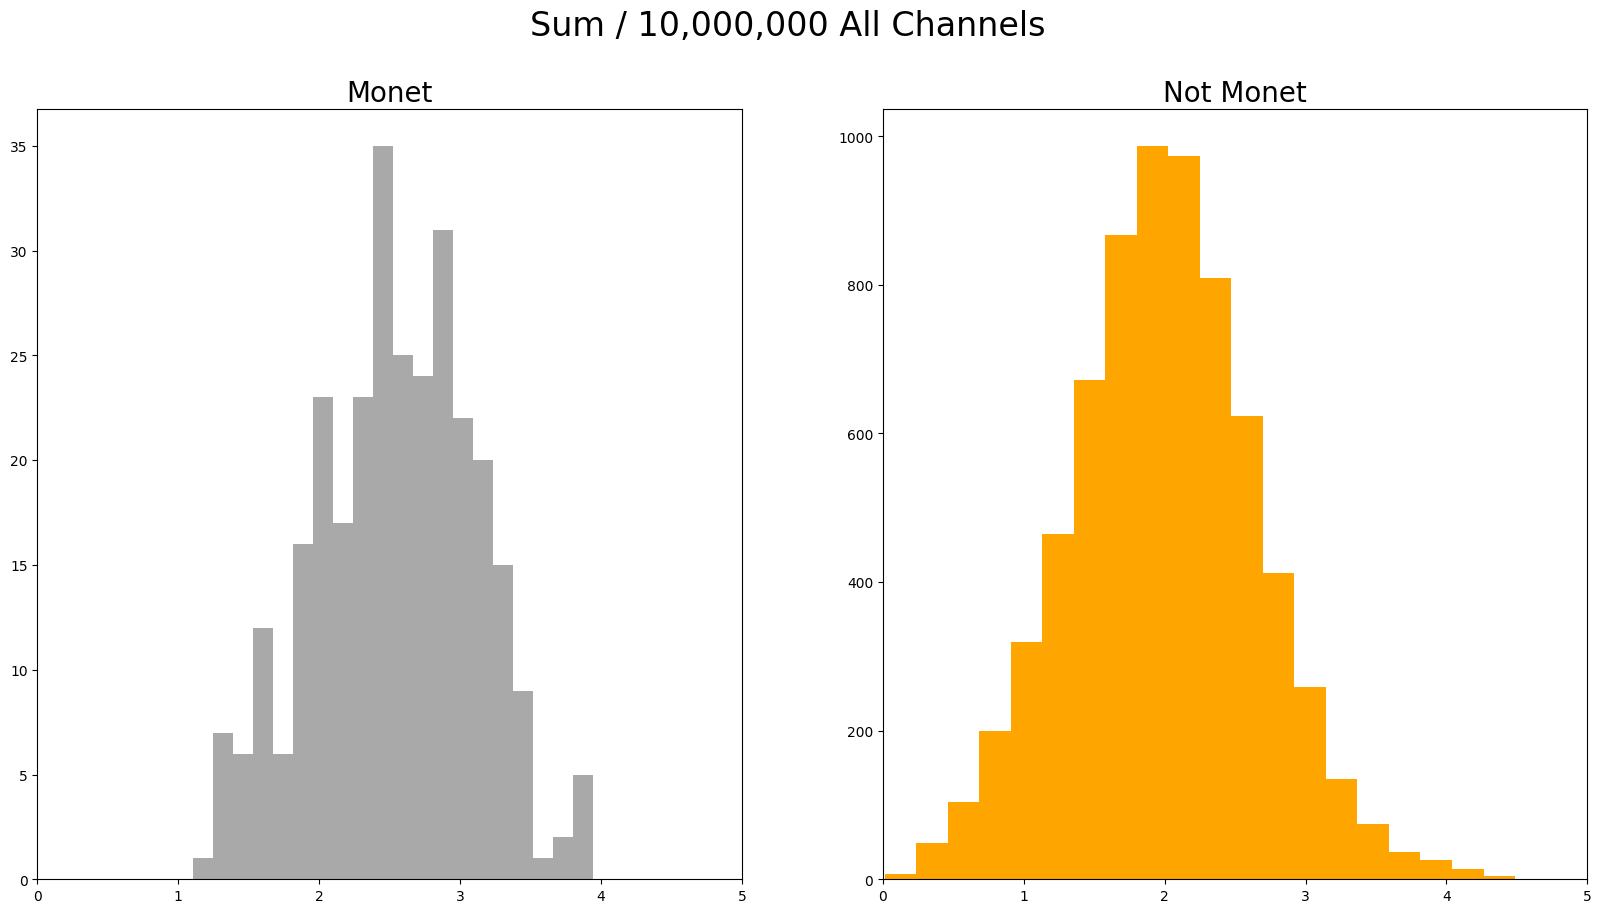

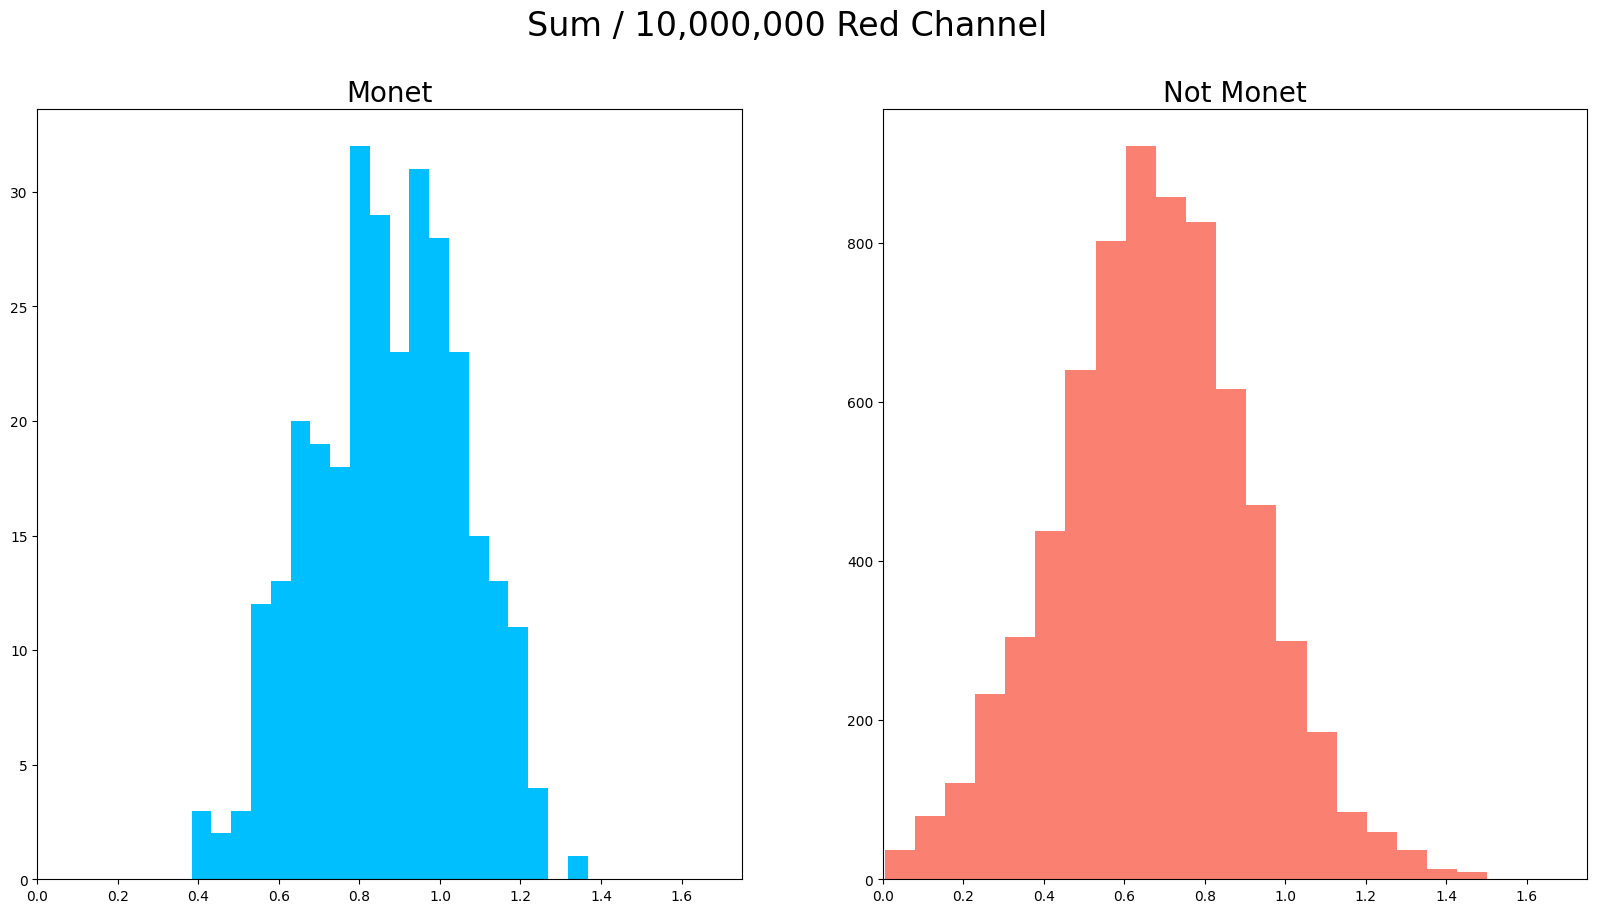

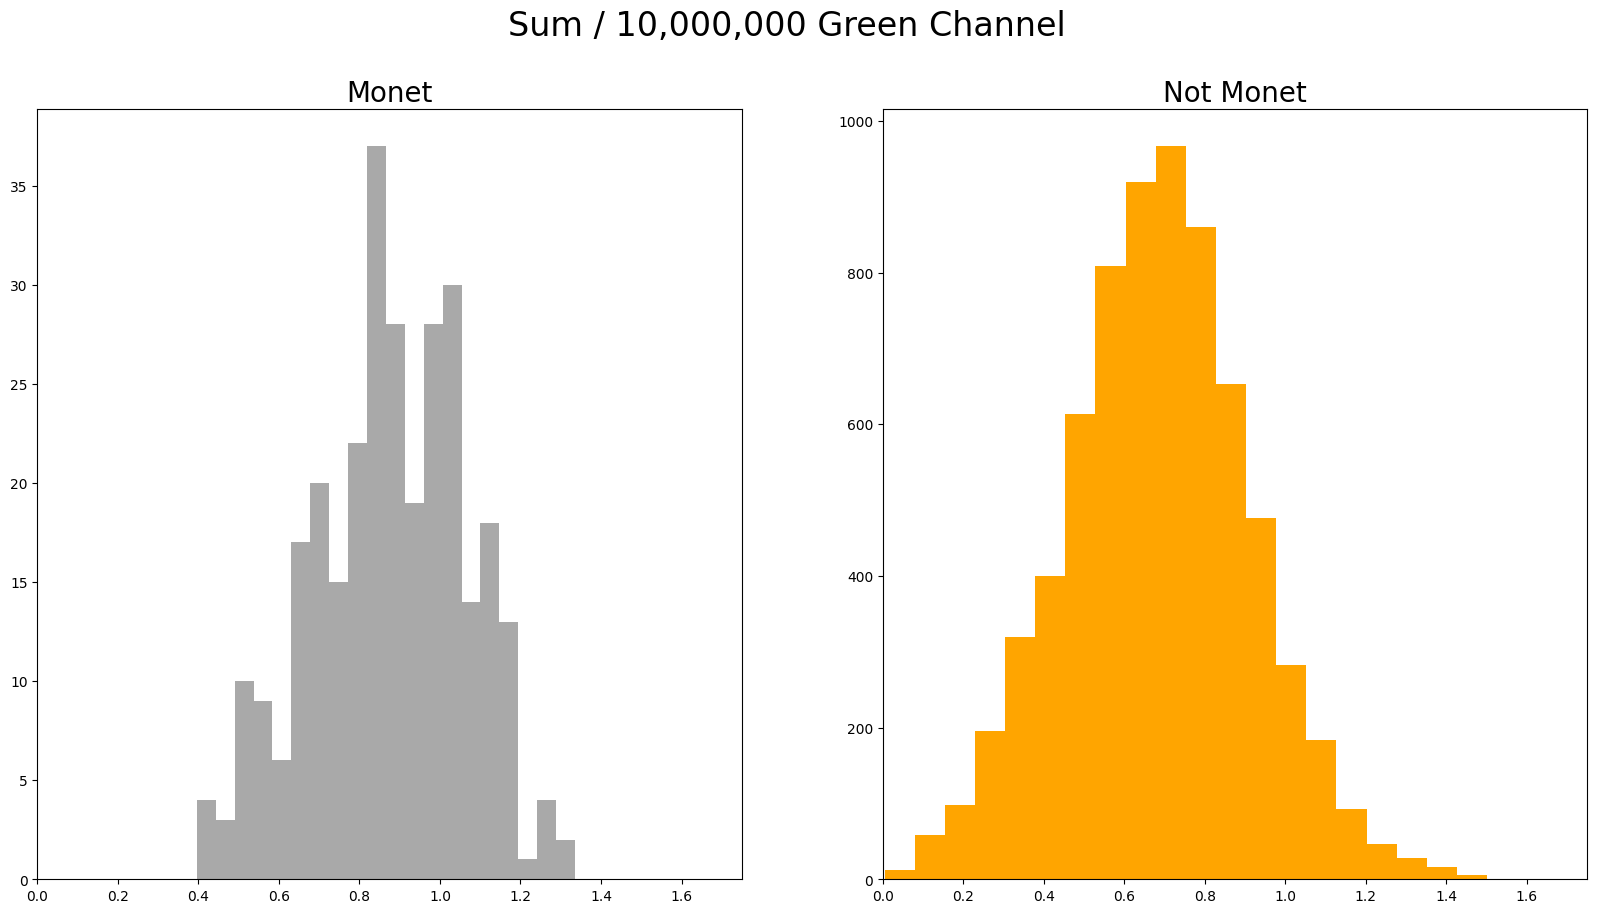

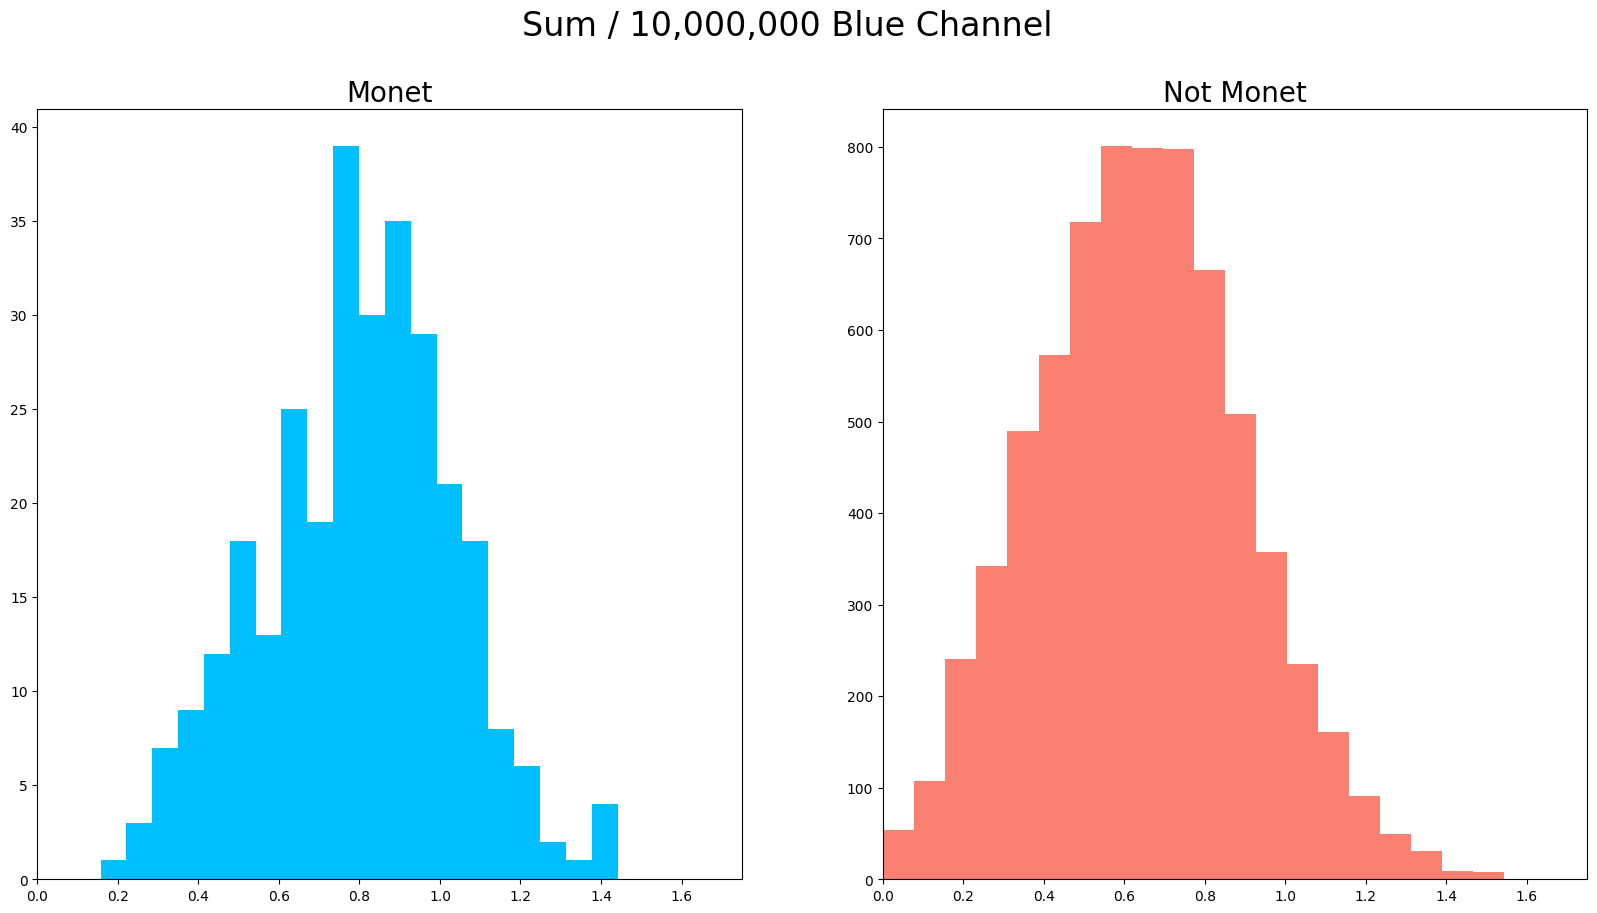

In [24]:
# Sum All
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(np.array(sum_all_channels_monet)/10000000, bins=20, color='darkgray');
axes[1].hist(np.array(sum_all_channels_photo)/10000000, bins=20, color='orange');
fig.suptitle('Sum / 10,000,000 All Channels', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,5]);
axes[1].set_xlim([0,5]);



# Sum Red
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(np.array(sum_red_channel_monet)/10000000, bins=20, color='deepskyblue');
axes[1].hist(np.array(sum_red_channel_photo)/10000000, bins=20, color='salmon');
fig.suptitle('Sum / 10,000,000 Red Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,1.75]);
axes[1].set_xlim([0,1.75]);



# Sum Green
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(np.array(sum_green_channel_monet)/10000000, bins=20, color='darkgray');
axes[1].hist(np.array(sum_green_channel_photo)/10000000, bins=20, color='orange');
fig.suptitle('Sum / 10,000,000 Green Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,1.75]);
axes[1].set_xlim([0,1.75]);



# Sum Blue
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(np.array(sum_blue_channel_monet)/10000000, bins=20, color='deepskyblue');
axes[1].hist(np.array(sum_blue_channel_photo)/10000000, bins=20, color='salmon');
fig.suptitle('Sum / 10,000,000 Blue Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,1.75]);
axes[1].set_xlim([0,1.75]);

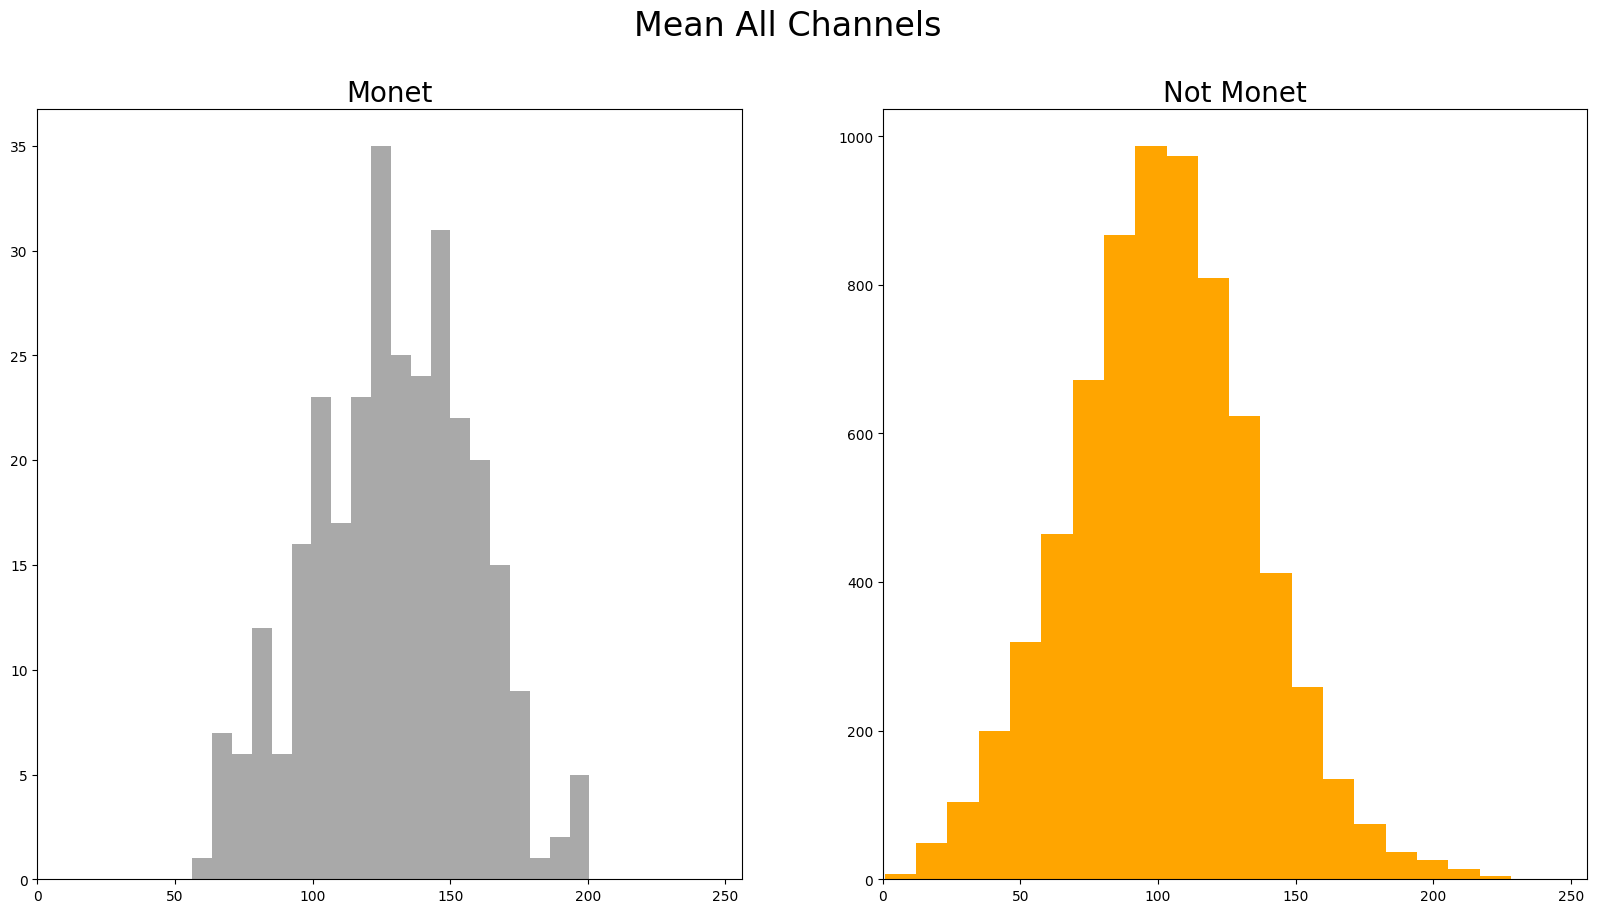

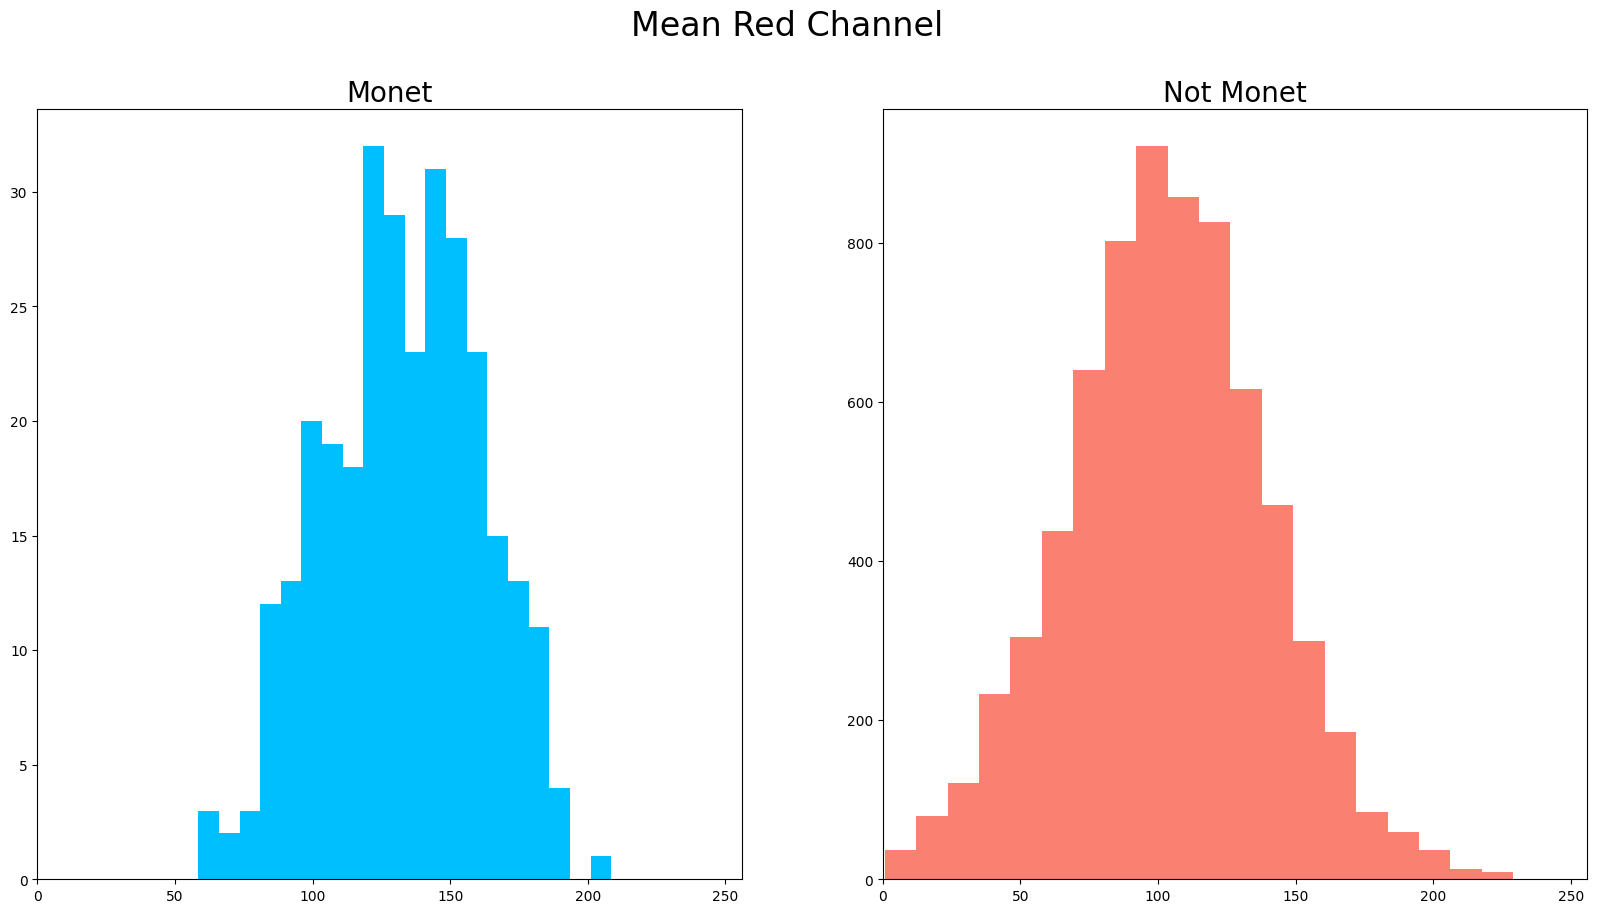

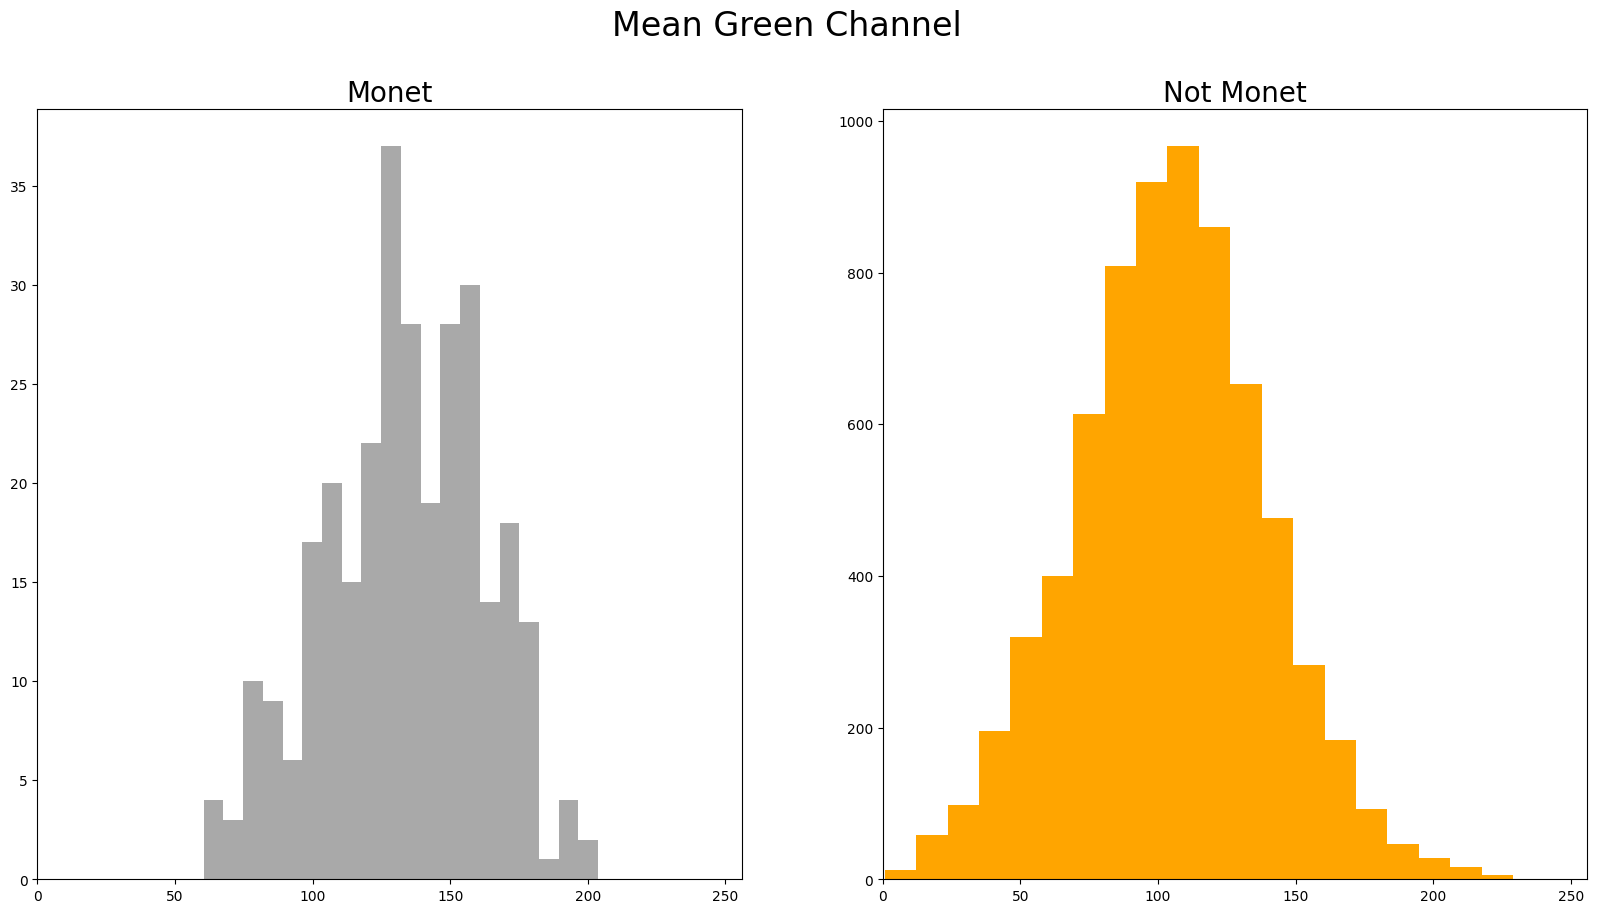

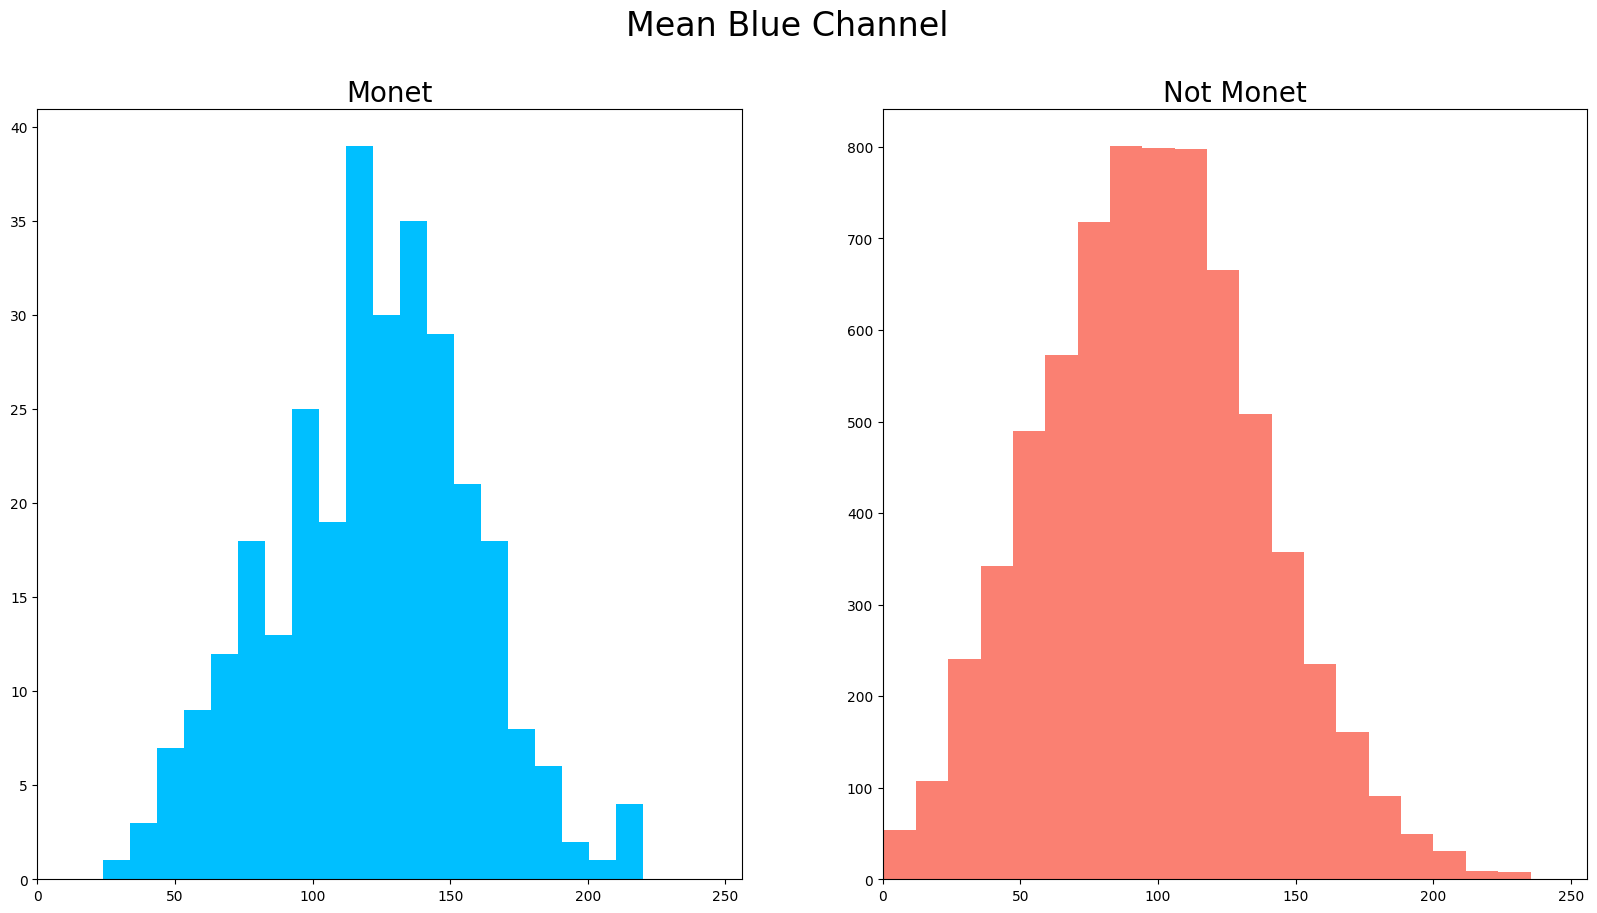

In [25]:
# Mean All
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(mean_all_channels_monet, bins=20, color='darkgray');
axes[1].hist(mean_all_channels_photo, bins=20, color='orange');
fig.suptitle('Mean All Channels', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,256]);
axes[1].set_xlim([0,256]);


# Mean Red
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(mean_red_channel_monet, bins=20, color='deepskyblue');
axes[1].hist(mean_red_channel_photo, bins=20, color='salmon');
fig.suptitle('Mean Red Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,256]);
axes[1].set_xlim([0,256]);


# Mean Green
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(mean_green_channel_monet, bins=20, color='darkgray');
axes[1].hist(mean_green_channel_photo, bins=20, color='orange');
fig.suptitle('Mean Green Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,256]);
axes[1].set_xlim([0,256]);


# Mean Blue
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(mean_blue_channel_monet, bins=20, color='deepskyblue');
axes[1].hist(mean_blue_channel_photo, bins=20, color='salmon');
fig.suptitle('Mean Blue Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,256]);
axes[1].set_xlim([0,256]);

The sum distributions all look somewhat normally distributed. The photo images have a wider distribution. The photo images also look slightly shifted to the left. We also see a more unified and clear peak usually across three bins in the photo images. One thing to call out is that we have significantly more photo images than Monet images, so we may be running into a scenario where too little data on the Monet plots shows up as false shape signals. We also need to be careful in that we are comparing Monet images to non-Monet images, but the actual test of the model will be to transform the non-Monet images into Monet images. What we see here is some evidence that there is at least a difference between the Monet and non-Monet images to start with.

The same trends of wider distributions, left-shifted distributions, and more solid peaks apply as well for the mean plots. Of the two, I prefer the mean plots to the sum plots. Each of the RGB channels have their peaks around 100 for mean pixel value for the photo images. It is a little murkier for the Monet images, with the peaks not being as thoroughly defined as in the photo images, though the mean does look higher.

It is not quite clear yet what exploratory analysis will help for cleanup or for modeling since the image data looks clean as of now and because much of what we would like to look at are the modified or generated images from the GAN, but we do not have those before modeling. So, we can return back to EDA if we run into more during modeling that needs further exploration.

So, for now, we will jump into modeling.

## Modeling

## References

Working with TensorFlow TFRecords
- https://www.tensorflow.org/tutorials/load_data/tfrecord
- https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564